# Load dataset

In [5]:
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader
import datasets
import pandas as pd
import numpy as np
from PIL import Image
import torch


class ClinicPartitioner(IidPartitioner):
    """Partitioner for splitting MNIST into 5 centers."""

    def __init__(self):
        super().__init__(num_partitions=5)

    def load_partition(self, partition_id: int) -> datasets.Dataset:
        """
        Creates 5 partitions of the dataset:
            1. 0's and 1's
            2. 2's and 3's
            3. 4's and 5's
            4. 6's and 7's
            5. 8's and 9's
        """

        # Return the entire dataset if partition_id is -1
        if (partition_id == -1):
            return self.dataset

        df = pd.DataFrame(
            {
                "image": [np.array(img) for img in self.dataset["image"]],
                "label": self.dataset["label"],
            }
        )

        df1 = df[df["label"].isin([0, 1])]
        df2 = df[df["label"].isin([2, 3])]
        df3 = df[df["label"].isin([4, 5])]
        df4 = df[df["label"].isin([6, 7])]
        df5 = df[df["label"].isin([8, 9])]

        def convertPDtoDS(df):
            return datasets.Dataset.from_dict({
                "image": [Image.fromarray(np.array(img)) for img in df["image"]],
                "label": df["label"],
            })

        splitDataset = [
            convertPDtoDS(df1),
            convertPDtoDS(df2),
            convertPDtoDS(df3),
            convertPDtoDS(df4),
            convertPDtoDS(df5),
        ]

        return splitDataset[partition_id]


trainPartitioner = None
testPartitioner = None


def load_data(partition_id: int, split: int):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global trainPartitioner, testPartitioner
    if trainPartitioner is None or testPartitioner is None:
        trainPartitioner = ClinicPartitioner()
        testPartitioner = ClinicPartitioner()
        ds = datasets.load_dataset(path="ylecun/mnist")
        ds = datasets.concatenate_datasets([ds["train"], ds["test"]])
        trainPartitioner.dataset = datasets.concatenate_datasets([ds.shard(5, i) for i in list(filter(lambda x: x != split, range(5)))])
        testPartitioner.dataset = ds.shard(5, split)
    partition_train = trainPartitioner.load_partition(partition_id)
    partition_test = testPartitioner.load_partition(partition_id)

    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["image"] = [(np.array(img, dtype=np.float32) / 256).flatten() for img in batch["image"]] # Transform images to float and normalize
        return batch


    partition_train = partition_train.with_transform(apply_transforms)
    partition_test = partition_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train, batch_size=32, shuffle=True)
    testloader = DataLoader(partition_test, batch_size=32)
    return trainloader, testloader



c:\Users\Bruger\Desktop\Bachelor-Project---Federated-Incremental-Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get model

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class NetDomainIL(nn.Module):
    def __init__(self):
        super(NetDomainIL, self).__init__()

        self.fc1 = nn.Linear(28*28, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x, i):
        x = F.relu(self.fc1(x))
        next_last_layer_1st_neuron = self.fc2(x)[:, i]
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x)), next_last_layer_1st_neuron



def trainDomainIL(net: nn.Module, trainloader, device):
    net.to(device)  # move model to GPU if available
    net.train()
    
    # Create optimizer
    criterion = torch.nn.BCELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    optimizer.zero_grad()
    cumulated_loss = 0.0
    
    # Update gradient in the model
    for batch in trainloader:
        images = batch["image"].to(device)
        labels = (batch["label"] % 2).to(device)
        labels = labels.cpu().type(torch.float32) [:, torch.newaxis]

        optimizer.zero_grad()

        outputs, _ = net(images, 0)

        # Get the loss and compute the gradient
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient
        optimizer.step()

        cumulated_loss += loss.item()
    
    return cumulated_loss / len(trainloader)

# Train and test model

In [27]:
net = NetDomainIL()
i = 0
trainloader_global, testloader_global = load_data(-1, i)
_, testloader01 = load_data(0, i)
_, testloader23 = load_data(1, i)
_, testloader45 = load_data(2, i)
_, testloader67 = load_data(3, i)
_, testloader89 = load_data(4, i)

# Get initial performance
epocs = 50
for i in range(epocs):
    print(f"Epoch {i+1}/{epocs}")
    # Train the model
    train_loss = trainDomainIL(net, trainloader_global, "cpu")
    print(f"Epoch {i+1}/{epocs}, train_loss: {train_loss:.4f}")


KeyboardInterrupt: 

In [7]:
class ClinicPartitioner2(IidPartitioner):
    """Partitioner for splitting MNIST into 5 centers."""

    def __init__(self):
        super().__init__(num_partitions=10)

    def load_partition(self, partition_id: int) -> datasets.Dataset:
        """
        Creates 5 partitions of the dataset:
            1. 0's and 1's
            2. 2's and 3's
            3. 4's and 5's
            4. 6's and 7's
            5. 8's and 9's
        """

        # Return the entire dataset if partition_id is -1
        if (partition_id == -1):
            return self.dataset

        df = pd.DataFrame(
            {
                "image": [np.array(img) for img in self.dataset["image"]],
                "label": self.dataset["label"],
            }
        )

        df0 = df[df["label"].isin([0])]
        df1 = df[df["label"].isin([1])]
        df2 = df[df["label"].isin([2])]
        df3 = df[df["label"].isin([3])]
        df4 = df[df["label"].isin([4])]
        df5 = df[df["label"].isin([5])]
        df6 = df[df["label"].isin([6])]
        df7 = df[df["label"].isin([7])]
        df8 = df[df["label"].isin([8])]
        df9 = df[df["label"].isin([9])]

        def convertPDtoDS(df):
            return datasets.Dataset.from_dict({
                "image": [Image.fromarray(np.array(img)) for img in df["image"]],
                "label": df["label"],
            })

        splitDataset = [
            convertPDtoDS(df0),
            convertPDtoDS(df1),
            convertPDtoDS(df2),
            convertPDtoDS(df3),
            convertPDtoDS(df4),
            convertPDtoDS(df5),
            convertPDtoDS(df6),
            convertPDtoDS(df7),
            convertPDtoDS(df8),
            convertPDtoDS(df9),
        ]

        return splitDataset[partition_id]

trainPartitioner2 = None
testPartitioner2 = None

def load_data_2(partition_id: int, split: int):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global trainPartitioner2, testPartitioner2
    if trainPartitioner2 is None or testPartitioner2 is None:
        trainPartitioner2 = ClinicPartitioner2()
        testPartitioner2 = ClinicPartitioner2()
        ds = datasets.load_dataset(path="ylecun/mnist")
        ds = datasets.concatenate_datasets([ds["train"], ds["test"]])
        trainPartitioner2.dataset = datasets.concatenate_datasets([ds.shard(5, i) for i in list(filter(lambda x: x != split, range(5)))])
        testPartitioner2.dataset = ds.shard(5, split)
    partition_train = trainPartitioner2.load_partition(partition_id)
    partition_test = testPartitioner2.load_partition(partition_id)

    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["image"] = [(np.array(img, dtype=np.float32) / 256).flatten() for img in batch["image"]] # Transform images to float and normalize
        return batch


    partition_train = partition_train.with_transform(apply_transforms)
    partition_test = partition_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train, batch_size=32, shuffle=True)
    testloader = DataLoader(partition_test, batch_size=32)
    return trainloader, testloader

In [77]:
def testDomainIL(net, testloader, device, index=0):
    """Validate the model on the test set."""
    net.to(device)
    criterion = torch.nn.BCELoss()
    loss = 0.0
    all_nll1stoutput = np.array([]) 
    with torch.no_grad():
        for batch in testloader:
            images = batch["image"].to(device)
            labels = (batch["label"] % 2).to(device) # Convert to binary labels (0 or 1)
            labels = labels.cpu().type(torch.float32) [:, torch.newaxis]
            outputs, nll1stoutput = net(images, index)
            loss += criterion(outputs, labels).item()
            all_nll1stoutput = np.concat([all_nll1stoutput, nll1stoutput.cpu().numpy()])
    loss = loss / len(testloader)
    return loss, all_nll1stoutput

In [13]:
_, loader0 = load_data_2(0, 0)
_, loader1 = load_data_2(1, 0)
_, loader2 = load_data_2(2, 0)
_, loader3 = load_data_2(3, 0)

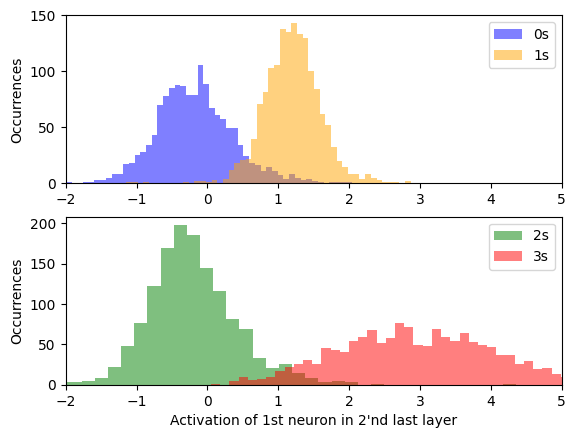

In [81]:
_, nll1stoutput0 = testDomainIL(net, loader0, "cpu", index=1)
_, nll1stoutput1 = testDomainIL(net, loader1, "cpu", index=1)
_, nll1stoutput2 = testDomainIL(net, loader2, "cpu", index=1)
_, nll1stoutput3 = testDomainIL(net, loader3, "cpu", index=1)

# Make histogram of nll1stoutput
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

ax[0].hist(nll1stoutput0, bins=50, alpha=0.5, label='0s', color='blue')
ax[0].hist(nll1stoutput1, bins=50, alpha=0.5, label='1s', color='orange')
ax[1].hist(nll1stoutput2, bins=50, alpha=0.5, label='2s', color='green')
ax[1].hist(nll1stoutput3, bins=50, alpha=0.5, label='3s', color='red')
# Set common xlabel and ylabel for subplots
ax[1].set_xlabel('Activation of 1st neuron in 2\'nd last layer')
ax[0].set_ylabel('Occurrences')
ax[1].set_ylabel('Occurrences')

ax[0].set_xlim(-2, 5)
ax[1].set_xlim(-2, 5)
ax[0].legend()
ax[1].legend()

fig.savefig("MNISTDomainShiftClassifier.svg", format='svg', bbox_inches='tight', dpi=300)